In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from glob import glob
import cv2

# TensorFlow and Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras import Model, layers



2024-11-30 13:06:26.331288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 13:06:26.475677: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 13:06:27.675958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 13:06:27.946521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732952188.591823  201318 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732952188.81

Artist: Random images of Weather


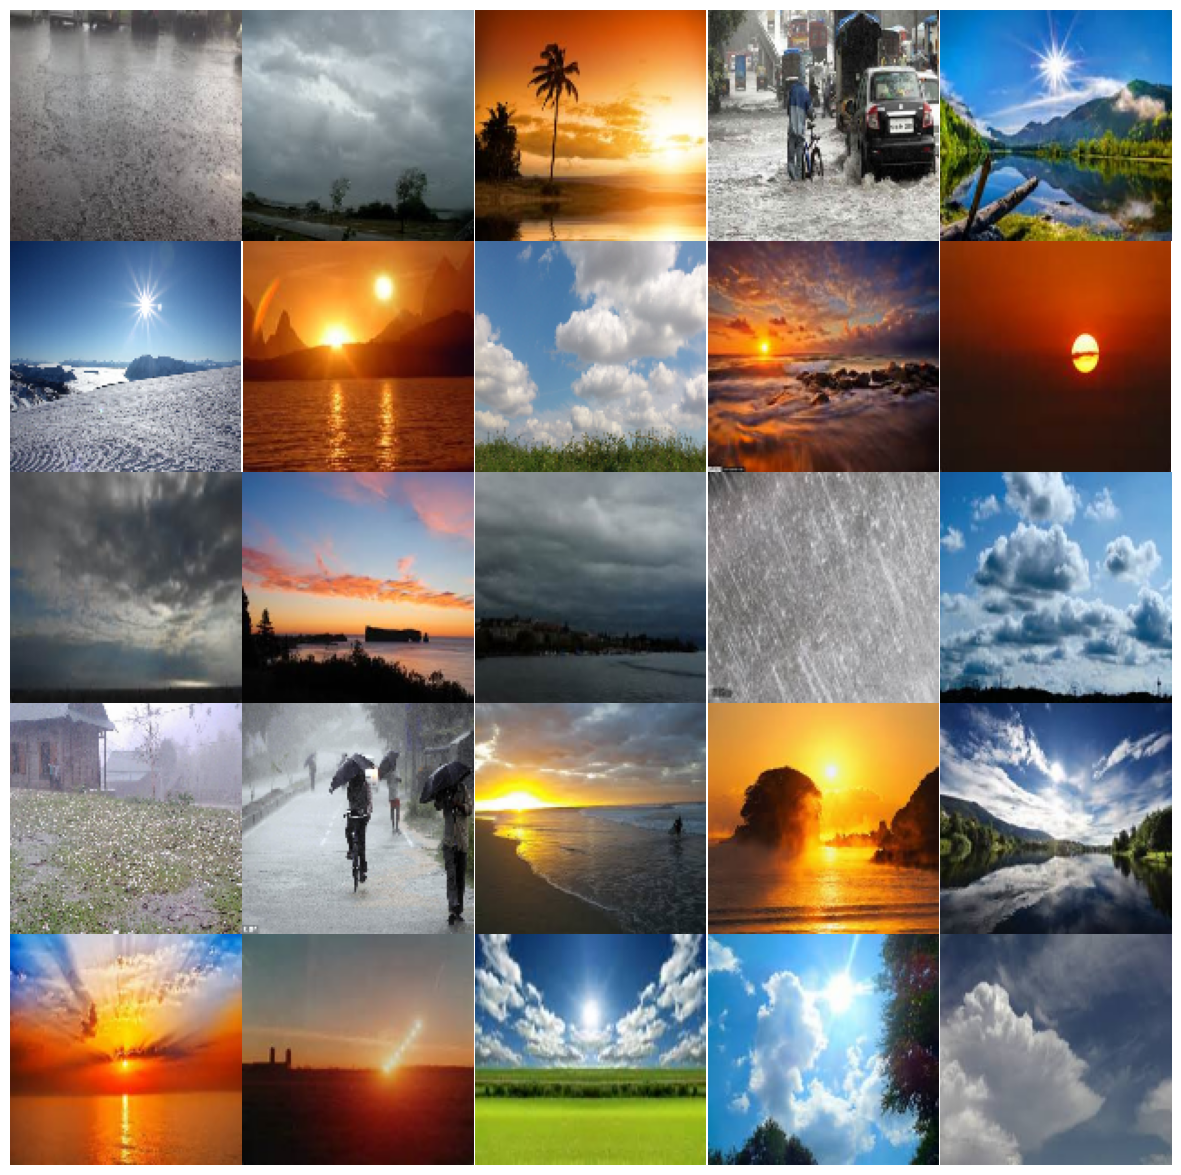

In [9]:
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt

def plotImages(artist, directory):
    print(f"Artist: {artist}")
    multipleImages = glob(os.path.join(directory, "*"))
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    i_ = 0
    for img_path in multipleImages[:25]:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        plt.subplot(5, 5, i_ + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        i_ += 1
    plt.show()

# Usage
plotImages("Random images of Weather", "/home/arjunrao/all_projects/GAN_proj/dataset2")


In [10]:
from tqdm import tqdm
from PIL import Image as Img
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop


2024-11-30 12:57:40.782647: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 12:57:40.873107: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 12:57:42.198348: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 12:57:42.857095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732951663.363970  197389 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732951663.49

In [ ]:
#w.o converting we get image shae error note that 
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Define paths and constants
PIC_DIR = '/home/arjunrao/all_projects/GAN_proj/dataset2/'
IMAGES_COUNT = 1125
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
WIDTH = 128
HEIGHT = 128

# Calculate crop rectangle
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

# Initialize image list
images = []

# Load and preprocess images
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT], desc="Processing Images"):
    pic_path = os.path.join(PIC_DIR, pic_file)
    with Image.open(pic_path) as pic:
        # Convert to RGB to handle grayscale or alpha channels
        pic = pic.convert("RGB")
        pic = pic.crop(crop_rect)
        pic.thumbnail((WIDTH, HEIGHT), Image.Resampling.LANCZOS)  # Resampling method
        images.append(np.array(pic, dtype=np.uint8))

# Convert to NumPy array
images = np.array(images, dtype=np.uint8)
print(f"Processed {len(images)} images. Array shape: {images.shape}")


Processing Images: 100%|██████████| 1125/1125 [00:03<00:00, 359.93it/s]

Processed 1125 images. Array shape: (1125, 128, 128, 3)


In [3]:
#Image shape
images = np.array(images) / 255
print(images.shape)

(1125, 128, 128, 3)


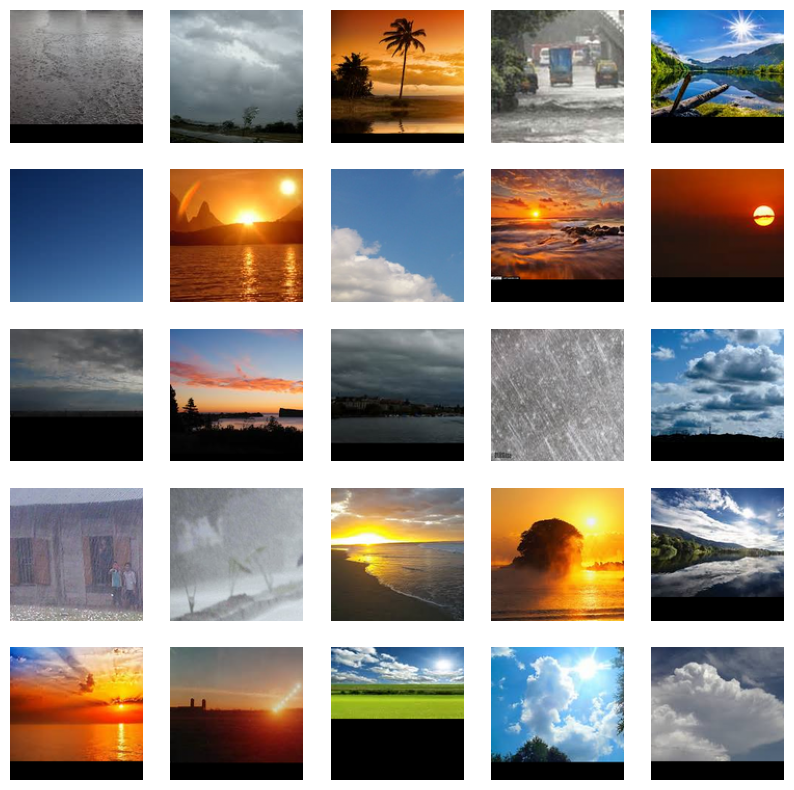

In [6]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [7]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, BatchNormalization

LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM,))

    # Dense and Reshape
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    # Upsampling with Conv2DTranspose
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Convolutions for refining the output
    x = Conv2D(64, 5, padding='same')(x)
    x = LeakyReLU()(x)

    # Final output layer
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

# Create the generator
generator = create_generator()
generator.summary()


2024-11-30 13:08:22.419101: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32768)          │     1,081,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 128)  │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 3)    │         9,411 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,395,971 (12.95 MB)

 Trainable params: 3,394,691 (12.95 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

def create_discriminator():
    disc_input = Input(shape=(128, 128, 3))  # Replace with your HEIGHT, WIDTH, CHANNELS
    
    # First convolution block
    x = Conv2D(64, 3, strides=1, padding='same', kernel_initializer='he_normal')(disc_input)
    x = LeakyReLU()(x)

    # Downsampling layers
    x = Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Flatten and Dropout
    x = Flatten()(x)
    x = Dropout(0.4)(x)

    # Output layer
    x = Dense(1, activation='sigmoid')(x)

    # Create model
    discriminator = Model(disc_input, x)

    # Optimizer
    optimizer = RMSprop(
        learning_rate=0.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    # Compile model
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return discriminator

# Create and summarize discriminator
discriminator = create_discriminator()
discriminator.summary()


/home/arjunrao/all_projects/GAN_proj/venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 512)      │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,988,417 (26.66 MB)

 Trainable params: 6,985,601 (26.65 MB)

 Non-trainable params: 2,816 (11.00 KB)